In [1]:
import math
import numpy as np
import random as rand
from numba import jit,int64,float64
import matplotlib.pyplot as plt
%matplotlib inline

#To increase cell width:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#Color-blind friendly colors to plot:
# CB_colors = ['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']
# CB_colors.reverse()
CB_colors = ['#00429d', '#93003a']

In [26]:
#The spacetime parameters. Let the population distribution of gene expression level be g:
g_min = 0
g_max = 100
dg = 0.4
#Defining a g_ghost which contains two extra `ghost' points at the edges:
g_ghost = np.arange(g_min-dg,g_max+2*dg,dg)
g = np.array(g_ghost[1:-1])
#The peak of the unregulated distribution:
g_peak = 0.5*(g_min+g_max)

#Parameters:
K = 1
delta = 1
alpha = 0.5

#Constant environment, T fixed:
dt = np.minimum(0.00005/K,0.01/delta)
T = 10
# #If tau is too large, we don't change:
# num_cycles = 8
# T = num_cycles*tau
TimeRange = np.arange(0,T,dt)
print(len(TimeRange))

#Tolerance to calculate entropy:
eps = 1e-100

#The noise variance D:
D = alpha*K*g_peak

#Checks:
print(f"K = {K}; 0.5*dg/dt = {0.5*dg/dt}")
print(f"D = {D}; 0.5*dg**2/dt = {0.5*dg**2/dt}")

#Stability check:
flag_stability=0
if (K>=int(0.5*dg/dt) or D>=int(0.5*dg**2/dt)):
    flag_stability=1
    print("Warning! FTCS unstable.")

200000
K = 1; 0.5*dg/dt = 4000.0
D = 25.0; 0.5*dg**2/dt = 1600.0000000000002


In [27]:
#First derivative, central difference method (used in the potential term K*d/dg (g*P)):
@jit("float64[:](float64[:],float64)",nopython=True)
def derv1(func,dx):
    func_left = func[0:-2]
    func_right = func[2:]
    #Below we calculate the first derivative using the central difference method:
    derivative = (func_right - func_left)/(2*dx)
    return derivative

#Second derivative using central difference, used in the diffusion term (D*d2/dg2 (P)):
@jit("float64[:](float64[:],float64)",nopython=True)
def derv2(func,dx):
    func_left = func[0:-2]
    func_right = func[2:]
    func_center = func[1:-1]
    #Below we calculate the second derivative, again using central difference method:
    derivative2 = (func_right + func_left - 2*func_center)/(dx**2)
    return derivative2

#Defining a Gaussian pdf - we'll need it for P(g,t=0), the initial distribution:
@jit(nopython=True)
def Gaussian(x,mu,sigma):
    dist = 1/(sigma*np.sqrt(2*np.pi))*np.exp(-0.5*((x-mu)/sigma)**2)
    return dist

#The function to calculate <f> dynamically, i.e. int_g f(g,s) P(g,t):
@jit(nopython=True)
def mean_wrt_P(func,P,g):
    integrand = func*P
    integral = np.trapz(integrand,g)
    return integral

#Defining the fitness function:
# @jit(["float64[:](float64[:],float64,float64)","float64(float64,float64,float64)"],nopython=True)
def fitness(g,s,delta):
    fit = delta*(g*s/(400+s) - (2/17)*g/(1-g/(1.8*g_max)))/g_max
    return fit

@jit(nopython=True)
def discrete_entropy(p_dist):
    p_dist = p_dist[np.where(np.clip(p_dist,eps,None)>eps)]
    return np.sum(p_dist*np.log2(1/p_dist))

@jit(nopython=True)
def cont_entropy(p_dist):
    p_dist = p_dist[np.where(np.clip(p_dist,eps,None)>eps)]
    return np.trapz(p_dist*np.log2(1/p_dist),dx=dg)

@jit(nopython=True)
def selection_const_noise(p0_unreg,p0_reg,s,K,alpha,delta,T,dt):
    #First, time:
#     dt = 0.0001/K
    TimeRange = np.arange(0,T,dt)
    
    #Then, define the fitness function:
    fit = delta*(g*s/(400+s) - (2/17)*g/(1-g/(1.8*g_max)))/g_max
    g_reg = g[np.argmax(fit)]

    #Now let's compare the effects of regulation vs selection:
    p_unreg = p0_unreg
    p_reg = p0_reg
    flag_unreg = 0
    flag_reg = 0
    
#     #Storing dynamic fitness:
#     dyn_fit_unreg = np.zeros_like

    #Now evolve it:
    for t in range(len(TimeRange)):
        #Constant noise:
        D_unreg = alpha*K*g_peak
        D_reg = alpha*K*g_peak

    #     #Checks:
    #     if (t%10==0):
    #         print(f"\nt={t}; g_mean_unreg={round(g_mean_unreg,2)}; D_unreg={round(D_unreg,2)}; max allowed={0.5*dg**2/dt}")
    #         print(f"t={t}; g_mean_reg={round(g_mean_reg,2)}; D_reg={round(D_reg,2)}; max allowed={0.5*dg**2/dt}")        

        #Now creating the expanded p's, with ghost points. The bulk points are the same in each. Unregulated:
        p_unreg_ghost = np.zeros(len(p_unreg)+2)
        p_unreg_ghost[1:-1] = p_unreg
        #Regulated:
        p_reg_ghost = np.zeros(len(p_reg)+2)
        p_reg_ghost[1:-1] = p_reg

        #Setting the value of the ghost points. This represents the zero flux boundary conditions. Unregulated:
        p_unreg_ghost[0] = p_unreg[1] + 2*dg*(K/D_unreg)*(g[0]-g_peak)*p_unreg[0]
        p_unreg_ghost[-1] = p_unreg[-2] + 2*dg*(K/D_unreg)*(g_peak-g[-1])*p_unreg[-1]
        #Regulated:
        p_reg_ghost[0] = p_reg[1] + 2*dg*(K/D_reg)*(g[0]-g_reg)*p_reg[0]
        p_reg_ghost[-1] = p_reg[-2] + 2*dg*(K/D_reg)*(g_reg-g[-1])*p_reg[-1]    

        #Now to solve the equation. Unregulated first:
        p_unreg += dt*((fit - mean_wrt_P(fit,p_unreg,g))*p_unreg \
                    + K*derv1((g_ghost-g_peak)*p_unreg_ghost,dg) + D_unreg*derv2(p_unreg_ghost,dg))
        p_reg += dt*((fit - mean_wrt_P(fit,p_reg,g))*p_reg \
                    + K*derv1((g_ghost-g_reg)*p_reg_ghost,dg) + D_reg*derv2(p_reg_ghost,dg))

#         #Finally, for the edge cases, we normalize:
#         if (flag_unreg==1 or delta>=1):
#             p_unreg = p_unreg/np.trapz(p_unreg,dx=dg)
#         if (flag_reg==1 or delta>=1):
#             p_reg = p_reg/np.trapz(p_reg,dx=dg)
            
    return p_unreg,p_reg

@jit(nopython=True)
def selection_dyn_const_noise(p0_unreg,p0_reg,sug_dyn,K,alpha,delta,T,dt):
    #First, time:
    TimeRange = np.arange(0,T,dt)    
    
    #Then, define the fitness function:
    s = sug_dyn[0]
    fit = delta*(g*s/(400+s) - (2/17)*g/(1-g/(1.8*g_max)))/g_max
    g_reg = g[np.argmax(fit)]

    #Now let's compare the effects of regulation vs selection:
    p_unreg = p0_unreg
    p_reg = p0_reg
    flag_unreg = 0
    flag_reg = 0
    
    #Storing dynamic fitness:
    dyn_fit_unreg, dyn_norm_fit_unreg, dyn_fit_reg, dyn_norm_fit_reg = np.zeros_like(TimeRange), np.zeros_like(TimeRange), np.zeros_like(TimeRange), np.zeros_like(TimeRange)
    #Dynamic distributions:
    dyn_p_unreg, dyn_p_reg = np.zeros((len(TimeRange),len(g))), np.zeros((len(TimeRange),len(g)))
    dyn_p_unreg[0,:], dyn_p_reg[0,:] = p_unreg, p_reg    

    #Now evolve it:
    for t in range(len(TimeRange)):
        #First setting the dynamic sugar and g_reg:
        s = sug_dyn[t]
        fit = delta*(g*s/(400+s) - (2/17)*g/(1-g/(1.8*g_max)))/g_max
        g_reg = g[np.argmax(fit)]
            
        #Constant noise:
        D_unreg = alpha*K*g_peak
        D_reg = alpha*K*g_peak

    #     #Checks:
    #     if (t%10==0):
    #         print(f"\nt={t}; g_mean_unreg={round(g_mean_unreg,2)}; D_unreg={round(D_unreg,2)}; max allowed={0.5*dg**2/dt}")
    #         print(f"t={t}; g_mean_reg={round(g_mean_reg,2)}; D_reg={round(D_reg,2)}; max allowed={0.5*dg**2/dt}")        

        #Now creating the expanded p's, with ghost points. The bulk points are the same in each. Unregulated:
        p_unreg_ghost = np.zeros(len(p_unreg)+2)
        p_unreg_ghost[1:-1] = p_unreg
        #Regulated:
        p_reg_ghost = np.zeros(len(p_reg)+2)
        p_reg_ghost[1:-1] = p_reg

        #Setting the value of the ghost points. This represents the zero flux boundary conditions. Unregulated:
        p_unreg_ghost[0] = p_unreg[1] + 2*dg*(K/D_unreg)*(g[0]-g_peak)*p_unreg[0]
        p_unreg_ghost[-1] = p_unreg[-2] + 2*dg*(K/D_unreg)*(g_peak-g[-1])*p_unreg[-1]
        #Regulated:
        p_reg_ghost[0] = p_reg[1] + 2*dg*(K/D_reg)*(g[0]-g_reg)*p_reg[0]
        p_reg_ghost[-1] = p_reg[-2] + 2*dg*(K/D_reg)*(g_reg-g[-1])*p_reg[-1]    

        #Now to solve the equation. Unregulated first:
        p_unreg += dt*((fit - mean_wrt_P(fit,p_unreg,g))*p_unreg \
                    + K*derv1((g_ghost-g_peak)*p_unreg_ghost,dg) + D_unreg*derv2(p_unreg_ghost,dg))
        p_reg += dt*((fit - mean_wrt_P(fit,p_reg,g))*p_reg \
                    + K*derv1((g_ghost-g_reg)*p_reg_ghost,dg) + D_reg*derv2(p_reg_ghost,dg))

#         #Finally, for the edge cases, we normalize:
#         if (flag_unreg==1 or delta>=1): #Because apparently this blows up temporarily when delta>1
#             p_unreg = p_unreg/np.trapz(p_unreg,dx=dg)
#         if (flag_reg==1 or delta>=1):
#             p_reg = p_reg/np.trapz(p_reg,dx=dg)
            
        #Storing the dynamic distributions:
        dyn_p_unreg[t,:], dyn_p_reg[t,:] = p_unreg, p_reg
            
        #Now calculating the dynamic fitnesses, absolute:
        dyn_fit_unreg[t] = mean_wrt_P(fit,p_unreg,g)
        dyn_fit_reg[t] = mean_wrt_P(fit,p_reg,g)
        #Normalized:
        dyn_norm_fit_unreg[t] = (dyn_fit_unreg[t] - np.min(fit))/(np.max(fit) - np.min(fit))
        dyn_norm_fit_reg[t] = (dyn_fit_reg[t] - np.min(fit))/(np.max(fit) - np.min(fit))
            
    return dyn_p_unreg, dyn_p_reg, dyn_fit_unreg, dyn_norm_fit_unreg, dyn_fit_reg, dyn_norm_fit_reg

In [28]:
fitness(g=100,s=10000000000000,delta=1) - fitness(g=100,s=0,delta=1)

0.99999999996

# Plotting the fitness function

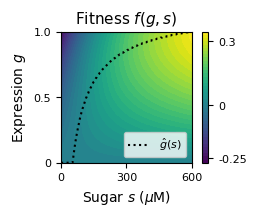

In [270]:
#Let's see plots:
#Now a contour plot. First define the mesh:
delta=1
sugars_contour = 6*g
S,G = np.meshgrid(sugars_contour,g)
f_2D = fitness(G,S,delta)
fig, ax = plt.subplots(1,1)

#Plotting the contour plot itself:
ax.set_box_aspect(1)
img = ax.contourf(S,G,f_2D, levels=50,cmap='viridis')
cbar=plt.colorbar(img,shrink=1,pad=0.02,ticks=[-0.25,0,0.3])
cbar.ax.set_yticklabels([-0.25,0,0.3],fontsize=8)
# cbar.set_label(r"$f(g,s)$",fontsize=10)
#Plotting the optimum expression level:
opt_g = np.empty_like(sugars_contour)
i=0
for s in sugars_contour:
    fit = fitness(g,s,delta)
    opt_g[i] = g[np.argmax(fit)]
    i+=1
ax.plot(sugars_contour,opt_g,'k:',label=r'$\hat{g}(s)$')
# ax.axvline(70,color='k',linestyle='--',label=r'$s$=70')
# ax.axvline(400,color='k',linestyle='dashdot',label=r'$s$=400')
# test1 = ax.get_yticklabels()
ax.set_xticks([0,300,600])
ax.set_yticks([0,50,100])
ax.set_yticklabels(['0','0.5','1.0'])
# ax.set_yticklabels(['0','0.2','0.4','0.6','0.8','1.0'])
ax.tick_params(axis='both', which='major', labelsize=8)
ax.tick_params(axis='both', which='minor', labelsize=6)
ax.set_xlabel(r"Sugar $s$ ($\mu$M)",fontsize=10)
ax.set_ylabel("Expression $g$",fontsize=10)
ax.set_title("Fitness $f(g,s)$",fontsize=11)
ax.legend(loc='best',fontsize=8)
fig.set_figheight(1.7)
# fig.set_figwidth(1.7)
# fig.savefig("1_fitness_landscape.svg",format="svg")
fig.savefig("fig1_A.pdf",format="pdf",dpi=600,bbox_inches='tight')

# Now plotting the dynamic distributions

In [164]:
#Now we initialize the parameters:
K = 0.1
delta = 12.5
alpha = 2
tau = 10

#Constant environment, T fixed:
dt = np.minimum(0.00005/K,0.005/delta)
# dt = 0.0001/K
# T = 10
# #If tau is too large, we don't change:
num_cycles = 2
T = num_cycles*tau
TimeRange = np.arange(0,T,dt)
print("No. of timepoints: ",len(TimeRange))

# The noise variance D:
D = alpha*K*g_peak

#Checks:
print(f"K = {K}; 0.5*dg/dt = {0.5*dg/dt}")
print(f"D = {D}; 0.5*dg**2/dt = {0.5*dg**2/dt}")

#Stability check:
flag_stability=0
if (K>=int(0.5*dg/dt) or D>=int(0.5*dg**2/dt)):
    flag_stability=1
    print("Warning! FTCS unstable.")

#The initial distributions:
p0_unreg = Gaussian(g,g_peak,np.maximum(np.sqrt(alpha*g_peak),1))
p0_unreg = p0_unreg/np.trapz(p0_unreg,dx=dg)
p0_reg = p0_unreg
p0_reg = p0_reg/np.trapz(p0_reg,dx=dg)

No. of timepoints:  50000
K = 0.1; 0.5*dg/dt = 500.0
D = 10.0; 0.5*dg**2/dt = 200.00000000000003


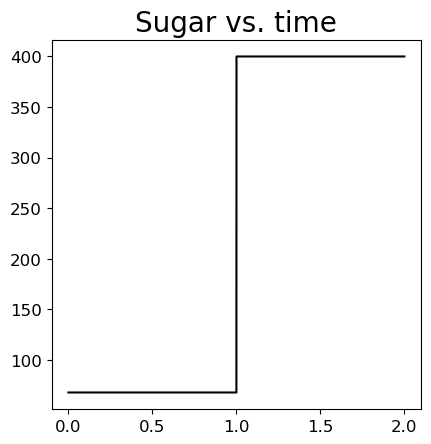

In [165]:
flag = False
sug_dyn = np.ones_like(TimeRange)
temp_sug = np.array([])

#The sugars:
sug_low = 68
sug_high = 400

for i in range(num_cycles):
    if (i%2==0):
        temp_sug = np.concatenate((temp_sug,sug_low*np.array_split(sug_dyn,num_cycles)[i]))
    elif (i%2==1):
        temp_sug = np.concatenate((temp_sug,sug_high*np.array_split(sug_dyn,num_cycles)[i]))
sug_dyn = temp_sug

fig,ax = plt.subplots(1,1)

ax.plot(TimeRange/tau,sug_dyn,c='k')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)
# ax.set_xlabel(r'Time $t$',fontsize=18)
# ax.set_ylabel('Sugar $s$',fontsize=18)
ax.set_title('Sugar vs. time', fontsize=20)
ax.set_box_aspect(1)
# ax.set_xticks((1,3))

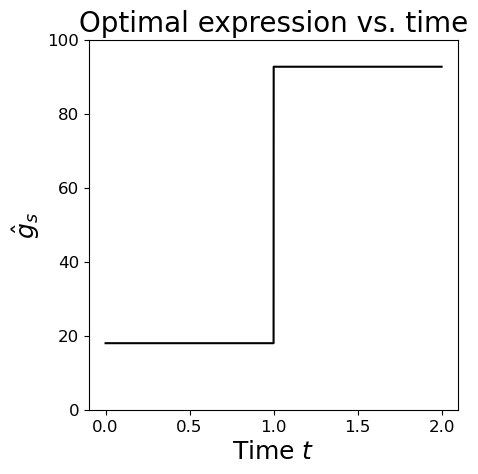

In [166]:
#Finding the g_opt as a function of time through sugar:
g_opt_dyn = np.ones_like(sug_dyn)

g_opt_low = g[np.argmax(fitness(g,sug_low,delta))]
g_opt_high = g[np.argmax(fitness(g,sug_high,delta))]

temp_g_opt = np.array([])
for i in range(num_cycles):
    if (i%2==0):
        temp_g_opt = np.concatenate((temp_g_opt,g_opt_low*np.array_split(g_opt_dyn,num_cycles)[i]))
    elif (i%2==1):
        temp_g_opt = np.concatenate((temp_g_opt,g_opt_high*np.array_split(g_opt_dyn,num_cycles)[i]))
g_opt_dyn = temp_g_opt

# for sug_idx in range(len(sug_dyn)):
#     g_opt_dyn[sug_idx] = g[np.argmax(fitness(g,sug_dyn[sug_idx],delta))]

# G,S = np.meshgrid(g,sug_dyn)
# fitness_2d = fitness(G,S,delta)
# g_opt_dyn = g[np.argmax(fitness_2d,axis=1)]

fig,ax = plt.subplots(1,1)
ax.set_ylim(bottom=g_min,top=g_max)
ax.plot(TimeRange/tau,g_opt_dyn,'k')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)
ax.set_xlabel(r'Time $t$',fontsize=18)
ax.set_ylabel(r'$\hat{g}_s$',fontsize=18)
ax.set_title('Optimal expression vs. time', fontsize=20)
# ax.set_xticks((0,2,4))
ax.set_box_aspect(1)

In [167]:
dyn_p_unreg, dyn_p_reg, dyn_fit_unreg, dyn_norm_fit_unreg, dyn_fit_reg, dyn_norm_fit_reg = selection_dyn_const_noise(p0_unreg,p0_reg,sug_dyn,K,alpha,delta,T,dt)


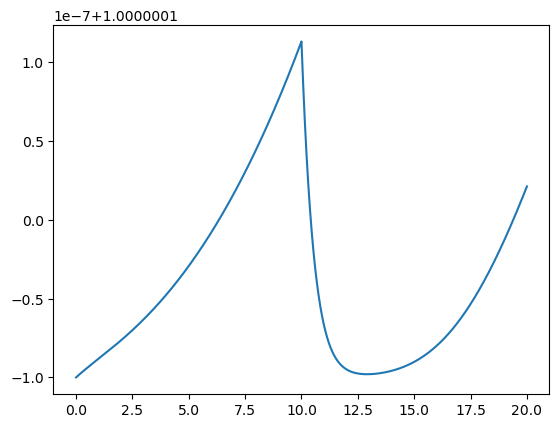

In [230]:
plt.plot(TimeRange,np.trapz(dyn_p_unreg,axis=1,dx=dg))

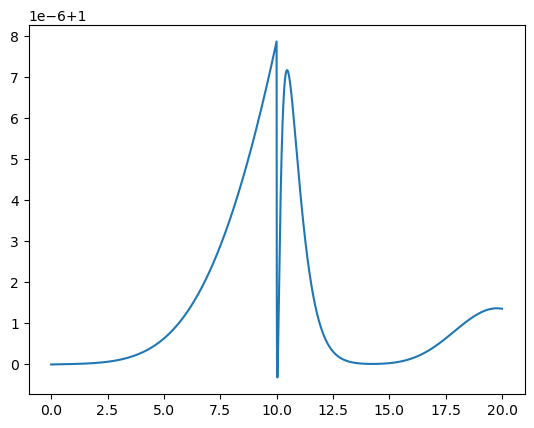

In [231]:
plt.plot(TimeRange,np.trapz(dyn_p_reg,axis=1,dx=dg))

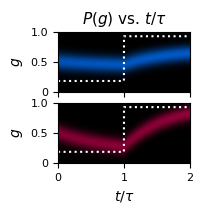

In [276]:
#plotting the distributions:
from matplotlib import cm 
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
#060BB
N = 256
no_reg = np.ones((N, 4))
no_reg[:, 0] = np.linspace(0, 0/256, N) # R = 55
no_reg[:, 1] = np.linspace(0, 90/256, N) # G = 126
no_reg[:, 2] = np.linspace(0, 200/256, N)  # B = 184
no_reg_cmp = ListedColormap(no_reg)
#93003A
with_reg = np.ones((N, 4))
with_reg[:, 0] = np.linspace(0, 147/256, N) # R = 255
with_reg[:, 1] = np.linspace(0, 0/256, N) # G = 127
with_reg[:, 2] = np.linspace(0, 58/256, N)  # B = 0
with_reg_cmp = ListedColormap(with_reg)


fig,ax = plt.subplots(2,1,sharex=True,figsize=[1.7,1.7])
ax[0].imshow(dyn_p_unreg.T,cmap=no_reg_cmp,origin='lower',aspect='auto',rasterized=True)
# cbar = plt.colorbar(pic,shrink=1.0,ticks=[0,0.02,0.04])
# cbar.ax.set_yticklabels([0,0.02,0.04],fontsize=8)
# xticks = ax.get_xticks()
# yticks = ax.get_yticks()
# ax.set_xticks(ticks = xticks[1:-1],labels=np.around(xticks[1:-1]*dt,2)/T)
# ax.set_yticks(ticks = yticks[1:-1],labels=np.around(yticks[1:-1]*dg,2)/g_max)
# ax.set_xticks(ticks = [0,T/2,T])
ax[0].set_xticks(ticks=[0,int((len(TimeRange)-1)/2),len(TimeRange)-1],labels=[0,1,2])
ax[0].set_yticks(ticks=[0,int((len(g)-1)/2),len(g)-1],labels=[0,int((len(g)-1)/2)*dg/g_max,(len(g)-1)*dg/g_max])
ax[0].tick_params(axis='both', which='major', labelsize=8)
ax[0].tick_params(axis='both', which='minor', labelsize=6)
ax[0].plot(g_opt_dyn/dg,'w:',label=r'$\hat{g}(s)$')
# ax.set_xlabel(r'Time $t$',fontsize=18)
ax[0].set_ylabel(r'$g$',fontsize=10)
ax[0].set_title(r'$P(g)$ vs. $t/\tau$',fontsize=11)

ax[1].imshow(dyn_p_reg.T,cmap=with_reg_cmp,origin='lower',aspect='auto',rasterized=True)
# cbar = plt.colorbar(pic,shrink=1.0,ticks=[0,0.02,0.04])
# cbar.ax.set_yticklabels([0,0.02,0.04],fontsize=8)
# xticks = ax.get_xticks()
# yticks = ax.get_yticks()
# ax.set_xticks(ticks = xticks[1:-1],labels=np.around(xticks[1:-1]*dt,2)/T)
# ax.set_yticks(ticks = yticks[1:-1],labels=np.around(yticks[1:-1]*dg,2)/g_max)
# ax.set_xticks(ticks = [0,T/2,T])
ax[1].set_xticks(ticks=[0,int((len(TimeRange)-1)/2),len(TimeRange)-1],labels=[0,1,2])
ax[1].set_yticks(ticks=[0,int((len(g)-1)/2),len(g)-1],labels=[0,int((len(g)-1)/2)*dg/g_max,(len(g)-1)*dg/g_max])
ax[1].tick_params(axis='both', which='major', labelsize=8)
ax[1].tick_params(axis='both', which='minor', labelsize=6)
ax[1].plot(g_opt_dyn/dg,'w:',label=r'$\hat{g}(s)$')
ax[1].set_xlabel(r'$t/\tau$',fontsize=10)
ax[1].set_ylabel(r'$g$',fontsize=10)

plt.subplots_adjust(hspace=0.18)
# fig.savefig("fig1_B.pdf",format="pdf",dpi=600,bbox_inches='tight')

# fig.set_figwidth(1.8)

# ax.legend(loc='lower right',fontsize=8)
# fig.set_figwidth(3)
# fig.savefig("30112022_POPULATIONS_setting_up_K,alpha,delta,tau_dyn_unreg.pdf",format="pdf",dpi=400)